In [53]:
import csv
import os.path
import numpy as np
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.layers import *
from keras.layers.normalization import BatchNormalization

from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import math
import pandas as pd

This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years.
The goal is to predict the number of shares in social networks (popularity).<br>
<br>
Reference material <br>
http://benalexkeen.com/feature-scaling-with-scikit-learn/ <br>
https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py <br>
https://archive.ics.uci.edu/ml/datasets/online+news+popularity <br><br>
Target is element 45, global_sentiment_polarity:     Text sentiment polarity

In [3]:
# loading of dataset 
dataset = []
labels = []
headers = []

def load_dataset(is_normalize=True, is_remove_outlier=True, select_top=50):
    """
    is_normalize: To normalize or keep orignal form
    is_remove_outlier: To remove outlier 
    select_top: select top important features using PCA (Principal component analysis)
    """
    global dataset, labels, headers
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        headers = next(reader) # the first row
        headers = headers[1:45] + headers[46:]
        headers = [x.strip(' ') for x in headers]
        
        temp_data = []
        temp_label = []

        for idx, row in enumerate(reader):            
            slice_row = row[1:45] + row[46:]
            temp_data.append(slice_row)
            temp_label.append(row[45])
        
        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))                
    
        if is_normalize:
            # it is important which type of normalization method you use
            scaler = preprocessing.MinMaxScaler()
            dataset = scaler.fit_transform(dataset)
            # last item uses MinMaxScaler
            labels = np.array(labels).reshape(-1, 1)
            scaler = preprocessing.MinMaxScaler()
            labels = scaler.fit_transform(labels)
            print('Data is normalize')
        else:
            print('No normalize apply')        
            
        if is_remove_outlier:
            dataset, labels = reject_outliers(dataset, labels)    
            
        if 0 < select_top < len(dataset):            
            top_features = pca_important_features(dataset, headers, top=select_top)
            feature_keys = [f[1] for f in top_features]
            df = pd.DataFrame(dataset, columns=headers)
            top_dataset = []
            for name in feature_keys:
                top_dataset.append(df.loc[:, name])
            dataset = np.transpose(top_dataset)
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def pca_important_features(dataset, headers, top=10):
    scaleFeatures = True
    pca = PCA(n_components=top)
    projected  = pca.fit_transform(dataset)
    top_features = extract_features(projected, pca.components_, headers, top)
    return top_features
    
def extract_features(transformed_features, components_, columns, top):
    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by top {0} importance:".format(top))
    for feature in important_features[:top]:
        print(feature)
    print()
    return important_features[:top]
        
def reject_outliers(dataset, labels, m=40):        
    """
    Higher the value 'm' more outliers
    """
    d = np.abs(labels - np.median(labels))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
        
    # remove outliers in dataset and labels
    sub_dataset = []
    sub_labels = []
    outlier_labels = []
    for idx, item in enumerate(s):        
        if item < m:
            sub_labels.append(labels[idx])
            sub_dataset.append(dataset[idx])        
        else:
            outlier_labels.append(labels[idx])
    print('Outlier removed: {0}'.format(len(outlier_labels)))
    return sub_dataset, sub_labels

In [4]:
# Splitting of dataset into train and test
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True, is_remove_outlier=False, select_top=40)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

# print(dataset[1])
# print(labels[:-10])

Data is normalize
Features by top 40 importance:
(1.0039281926912549, 'data_channel_is_world')
(0.8751808255851447, 'data_channel_is_tech')
(0.7164838485444, 'LDA_02')
(0.7024504221910417, 'LDA_04')
(0.6434857382004875, 'data_channel_is_entertainment')
(0.4565516321031484, 'LDA_03')
(0.28292902436467854, 'LDA_01')
(0.27539369926268287, 'title_subjectivity')
(0.27141665959140926, 'abs_title_subjectivity')
(0.26160822753207413, 'timedelta')
(0.24505377501984643, 'data_channel_is_bus')
(0.19651813942736576, 'kw_min_avg')
(0.19502718246107267, 'LDA_00')
(0.17612026338273676, 'min_negative_polarity')
(0.1721170943797155, 'abs_title_sentiment_polarity')
(0.16657852967652695, 'rate_positive_words')
(0.15599370115509187, 'kw_max_max')
(0.1357431818887493, 'kw_avg_max')
(0.12354845853099773, 'max_positive_polarity')
(0.11758166273091118, 'rate_negative_words')
(0.11283502834539456, 'num_keywords')
(0.10508532678501499, 'kw_min_min')
(0.09904889442894382, 'global_rate_positive_words')
(0.0795681

dataset (39644, 40)
labels (39644, 1)
Labels max value: 1.0
Labels min value: 0.0
Labels avg value: 0.45743886217973123


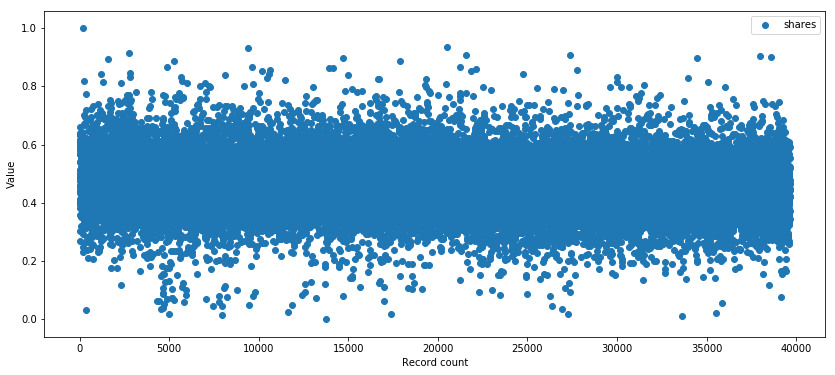

In [5]:
# Quick view of processed datasets
print('dataset {0}'.format(dataset.shape))
print('labels {0}'.format(labels.shape))
print('Labels max value: {0}'.format(np.max(labels)))
print('Labels min value: {0}'.format(np.min(labels)))
print('Labels avg value: {0}'.format(np.average(labels)))

def show_graph(data):
    plt.figure(figsize=(14,6))
    plt.xlabel("Record count")
    plt.ylabel("Value")
    plt.title("")
    x = list(range(len(data)))
    plt.scatter(x, [pt[0] for pt in data], label='shares')
    plt.legend(loc='upper right')
    plt.show()

def show_histogram(data):
    plt.figure(figsize=(14,6))
    plt.hist(data, 100)
    plt.show()

show_graph(labels)
# show_histogram(labels)

In [70]:
# build models for ensemble
# Multi layer perceptron
l2_kernal = 0.0001
model_mlp = Sequential()
model_mlp.add(Dense(512, input_dim=40, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(l2_kernal)))

model_mlp.compile(loss='mean_squared_error',
         optimizer=RMSprop(lr=0.0001),
         metrics=['mse'])

# Radial basis function model
model_rbf = Sequential()
rbflayer = RBFLayer(40,
                    initializer=InitCentersRandom(x_train), 
                    betas=1.5,
                    input_shape=(40,))
model_rbf.add(rbflayer)
model_rbf.add(Dense(1, activation='sigmoid'))

model_rbf.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.001),
              metrics=['mse'])

# load weights for both models
saved_weights_mlp = 'best_weights_mlp.h5'
saved_weights_rbf = 'best_weights_rbf.h5'

# load weights if any
if os.path.isfile(saved_weights_mlp):
    model_mlp.load_weights(saved_weights_mlp)
    print("MLP weights loaded: {0}".format(saved_weights_mlp))

if os.path.isfile(saved_weights_rbf):
    model_rbf.load_weights(saved_weights_rbf)
    print("RBF weights loaded: {0}".format(saved_weights_rbf))    
print()

print('Multi layer perceptron')
model_mlp.summary()
print()
print()
print('Radial basis function')
model_rbf.summary()

models = [model_mlp, model_rbf]

MLP weights loaded: best_weights_mlp.h5
RBF weights loaded: best_weights_rbf.h5

Multi layer perceptron
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 512)               20992     
_________________________________________________________________
dropout_49 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_50 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_51 (Dropout)         (None, 256)               0         
______________________________________

### Creating ensemble model using averaging

In [71]:
def ensemble(models, model_input):
    yModels=[model(model_input) for model in models] 
    yAvg=Average()(yModels)
    modelEns = Model(inputs=model_input, outputs=yAvg, name='ensemble')
    return modelEns

model_input = Input(shape=x_train[0].shape)
ensemble_model = ensemble(models, model_input)
ensemble_model.compile(loss='mean_squared_error',
         optimizer=RMSprop(lr=0.0001),
         metrics=['mse'])

ensemble_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, 1)            251137      input_31[0][0]                   
__________________________________________________________________________________________________
sequential_25 (Sequential)      (None, 1)            1681        input_31[0][0]                   
__________________________________________________________________________________________________
average_19 (Average)            (None, 1)            0           sequential_24[1][0]              
                                                                 sequential_25[1][0]              
Total para

7929/7929 [==============================] - 1s 123us/step
actual max 0.9031642116749825
actual min 0.012073623776047593
actual median 0.43390746369469224
predict max 0.6979774832725525
predict min 0.20540067553520203
predict median 0.4362124800682068

loss: 0.001837
mean_squared_error: 0.000634
root_mse: 0.025184
explained_variance_score: 0.888637
mean_absolute_error: 0.016583
mean_squared_log_error: 0.000305
median_absolute_error: 0.010795
r2_score: 0.88859


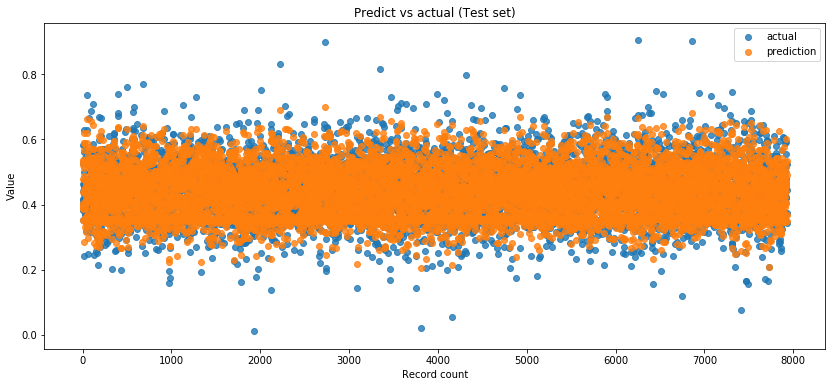

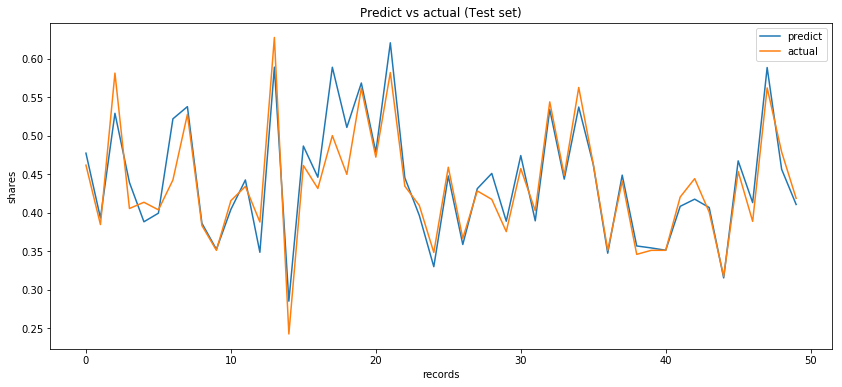

In [72]:
# showing results
scores = ensemble_model.evaluate(x_test, y_test)

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = ensemble_model.predict(x_test)

root_mse = math.sqrt(scores[1])
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print('actual max {0}'.format(np.max(y_test)))
print('actual min {0}'.format(np.min(y_test)))
print('actual median {0}'.format(np.median(y_test)))
print('predict max {0}'.format(np.max(y_pred)))
print('predict min {0}'.format(np.min(y_pred)))
print('predict median {0}'.format(np.median(y_pred)))
print()
print("{0}: {1}".format(ensemble_model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}".format(ensemble_model.metrics_names[1], round(scores[1], 6)))
print('root_mse: {0}'.format(round(root_mse, 6)))
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

# plt.figure(figsize=(14,6))
# plt.hist(y_pred, 100)
# plt.hist(y_test, 100)
# plt.show()

# plt.figure(figsize=(14,6))
# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.title('Train vs validation loss')
# plt.ylabel('mse')
# plt.xlabel('epochs')
# plt.legend(['mse', 'val_mse'], loc='upper right')
# plt.show()

plt.figure(figsize=(14,6))
plt.xlabel("Record count")
plt.ylabel("Value")
plt.title("Predict vs actual (Test set)")
x = list(range(len(y_pred)))
# plt.ylim(0, 1)
plt.scatter(x, [pt[0] for pt in y_test], label='actual', alpha=0.8)
plt.scatter(x, [pt[0] for pt in y_pred], label='prediction', alpha=0.8)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14,6))
plt.title('Predict vs actual (Test set)')
plt.plot(y_pred[:50])
plt.plot(y_test[:50])
plt.ylabel('shares')
plt.xlabel('records')
plt.legend(['predict', 'actual'], loc='upper right', borderaxespad=0.5)
plt.show()